# 平均スペクトルを用いた階層型クラスタリング

--- ステップ1: 平均スペクトルデータの作成 ---
データセットの結合が完了しました。
各プラスチックの平均スペクトルを計算しました。

--- ステップ2: コサイン類似度行列の作成 ---
コサイン類似度行列:
label_name       ABS      HDPE      LDPE        PC       PET      PMMA  \
label_name                                                               
ABS         1.000000  0.802510  0.746741  0.758124  0.827270  0.703611   
HDPE        0.802510  1.000000  0.994302  0.982626  0.778022  0.969175   
LDPE        0.746741  0.994302  1.000000  0.987479  0.726906  0.983308   
PC          0.758124  0.982626  0.987479  1.000000  0.737637  0.986065   
PET         0.827270  0.778022  0.726906  0.737637  1.000000  0.674994   
PMMA        0.703611  0.969175  0.983308  0.986065  0.674994  1.000000   
PP          0.752308  0.993448  0.998468  0.992135  0.728993  0.989409   
PS          0.908515  0.949318  0.928957  0.940702  0.803164  0.898342   
PVC         0.908913  0.962588  0.942680  0.934471  0.777069  0.921516   

label_name        PP        PS       PVC  
label_name                     

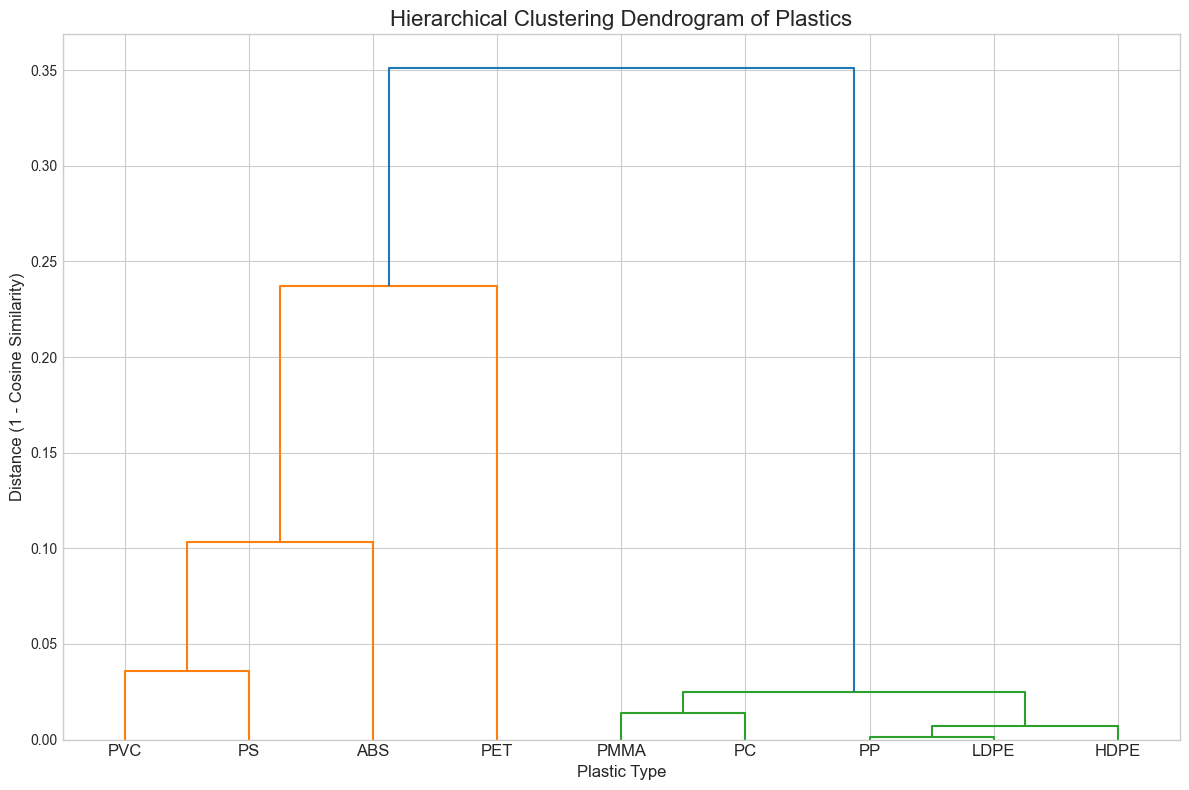

In [9]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# --- ユーザー設定 ---
main_dir = Path("C:/Users/sawamoto24/sawamoto24/master/microplastic/data")
dataset1_folder_name = "MPs_20250911"
dataset2_folder_name = "MPs_20250905_2"
csv_filename = "pixel_features_plastics_only.csv"
# --------------------

# --- ステップ1: 平均スペクトルデータの作成 ---
print("--- ステップ1: 平均スペクトルデータの作成 ---")

# 1. 2つのデータセットを読み込み、結合する
try:
    df1 = pd.read_csv(main_dir / dataset1_folder_name / "csv" / csv_filename)
    df2 = pd.read_csv(main_dir / dataset2_folder_name / "csv" / csv_filename)
    combined_df = pd.concat([df1, df2], ignore_index=True)
    print("データセットの結合が完了しました。")
except FileNotFoundError as e:
    print(f"エラー: CSVファイルが見つかりません: {e.filename}")
    exit()

# 2. 特徴量とラベルに分割
X_full = combined_df.drop(columns=['label_name', 'original_index'])
y_full = combined_df['label_name']

# 3. 各プラスチックの平均スペクトルを計算
mean_spectra_df = pd.concat([X_full, y_full], axis=1).groupby('label_name').mean()
print("各プラスチックの平均スペクトルを計算しました。")

# --- ステップ2: コサイン類似度行列の作成 ---
print("\n--- ステップ2: コサイン類似度行列の作成 ---")

# コサイン類似度を計算 (値が1に近いほど似ている)
similarity_matrix = cosine_similarity(mean_spectra_df)
similarity_df = pd.DataFrame(similarity_matrix, index=mean_spectra_df.index, columns=mean_spectra_df.index)
print("コサイン類似度行列:")
print(similarity_df)

# --- ステップ3: 階層的クラスタリングの実行 ---
print("\n--- ステップ3: 階層的クラスタリングの実行 ---")

# 類似度(similarity)を距離(distance)に変換
distance_matrix = 1 - similarity_matrix

# 浮動小数点誤差を補正するため、対角成分を強制的に0にする
np.fill_diagonal(distance_matrix, 0)

condensed_distance = squareform(distance_matrix)

# 階層的クラスタリングを実行
linked = hierarchy.linkage(condensed_distance, method='ward')
print("階層的クラスタリングが完了しました。")


# --- ステップ4: デンドログラムの可視化 ---
print("\n--- ステップ4: デンドログラムの可視化 ---")
# ★★★ スタイルシート名を新しいバージョン対応のものに変更 ★★★
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

# デンドログラムを描画
hierarchy.dendrogram(
    linked,
    orientation='top',
    labels=mean_spectra_df.index,
    distance_sort='descending',
    show_leaf_counts=True
)

plt.title('Hierarchical Clustering Dendrogram of Plastics', fontsize=16)
plt.ylabel('Distance (1 - Cosine Similarity)', fontsize=12)
plt.xlabel('Plastic Type', fontsize=12)
plt.tight_layout()
plt.show()



---